# Learning Neural Network Subspaces

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm.notebook import tqdm

In [3]:
save_root_path = '/content/drive/MyDrive/lsp'

Mounted at /content/drive


**Code is heavily based on official implementation**: https://github.com/apple/learning-subspaces

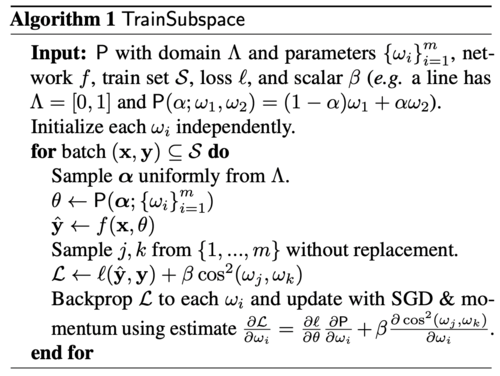

# 1. Define NParamsModules

In [4]:
class SubspaceConv(nn.Conv2d):
    def forward(self, x):
        # call get_weight, which samples from the subspace, then use the corresponding weight.
        w = self.get_weight()
        x = F.conv2d(
            x,
            w,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )
        return x

class SubspaceBN(nn.BatchNorm2d):
    def forward(self, input):
        # call get_weight, which samples from the subspace, then use the corresponding weight.
        w, b = self.get_weight()

        # The rest is code in the PyTorch source forward pass for batchnorm.
        if self.momentum is None:
            exponential_average_factor = 0.0
        else:
            exponential_average_factor = self.momentum

        if self.training and self.track_running_stats:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked = self.num_batches_tracked + 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(
                        self.num_batches_tracked
                    )
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum
        if self.training:
            bn_training = True
        else:
            bn_training = (self.running_mean is None) and (
                self.running_var is None
            )
        return F.batch_norm(
            input,
            # If buffers are not to be tracked, ensure that they won't be updated
            self.running_mean
            if not self.training or self.track_running_stats
            else None,
            self.running_var
            if not self.training or self.track_running_stats
            else None,
            w,
            b,
            bn_training,
            exponential_average_factor,
            self.eps,
        )

In [5]:
class TwoParamConv(SubspaceConv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight1 = nn.Parameter(torch.zeros_like(self.weight))

    def initialize(self, initialize_fn):
        initialize_fn(self.weight1)


class ThreeParamConv(SubspaceConv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight1 = nn.Parameter(torch.zeros_like(self.weight))
        self.weight2 = nn.Parameter(torch.zeros_like(self.weight))

    def initialize(self, initialize_fn):
        initialize_fn(self.weight1)
        initialize_fn(self.weight2)


class TwoParamBN(SubspaceBN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight1 = nn.Parameter(torch.Tensor(self.num_features))
        self.bias1 = nn.Parameter(torch.Tensor(self.num_features))
        torch.nn.init.ones_(self.weight1)
        torch.nn.init.zeros_(self.bias1)


class ThreeParamBN(SubspaceBN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.weight1 = nn.Parameter(torch.Tensor(self.num_features))
        self.bias1 = nn.Parameter(torch.Tensor(self.num_features))
        self.weight2 = nn.Parameter(torch.Tensor(self.num_features))
        self.bias2 = nn.Parameter(torch.Tensor(self.num_features))
        torch.nn.init.ones_(self.weight1)
        torch.nn.init.zeros_(self.bias1)
        torch.nn.init.ones_(self.weight2)
        torch.nn.init.zeros_(self.bias2)


class LinesConv(TwoParamConv):
    def get_weight(self):
        w = (1 - self.alpha) * self.weight + self.alpha * self.weight1
        return w


class LinesBN(TwoParamBN):
    def get_weight(self):
        w = (1 - self.alpha) * self.weight + self.alpha * self.weight1
        b = (1 - self.alpha) * self.bias + self.alpha * self.bias1
        return w, b


class CurvesConv(ThreeParamConv):
    def get_weight(self):
        w = (
            ((1 - self.alpha) ** 2) * self.weight
            + 2 * self.alpha * (1 - self.alpha) * self.weight2
            + (self.alpha ** 2) * self.weight1
        )
        return w


class CurvesBN(ThreeParamBN):
    def get_weight(self):
        w = (
            ((1 - self.alpha) ** 2) * self.weight
            + 2 * self.alpha * (1 - self.alpha) * self.weight2
            + (self.alpha ** 2) * self.weight1
        )
        b = (
            ((1 - self.alpha) ** 2) * self.bias
            + 2 * self.alpha * (1 - self.alpha) * self.bias2
            + (self.alpha ** 2) * self.bias1
        )
        return w, b


class SimplexConv3(SubspaceConv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight1 = nn.Parameter(torch.zeros_like(self.weight))
        self.weight2 = nn.Parameter(torch.zeros_like(self.weight))

    def initialize(self, initialize_fn):
        initialize_fn(self.weight1)
        initialize_fn(self.weight2)

    def get_weight(self):
        mult = 1 - self.t1 - self.t2
        w = mult * self.weight + self.t1 * self.weight1 + self.t2 * self.weight2
        return w


class SimplexBN3(SubspaceBN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight1 = nn.Parameter(torch.Tensor(self.num_features))
        self.bias1 = nn.Parameter(torch.Tensor(self.num_features))
        self.weight2 = nn.Parameter(torch.Tensor(self.num_features))
        self.bias2 = nn.Parameter(torch.Tensor(self.num_features))
        torch.nn.init.ones_(self.weight1)
        torch.nn.init.zeros_(self.bias1)
        torch.nn.init.ones_(self.weight2)
        torch.nn.init.zeros_(self.bias2)

    def get_weight(self):
        mult = 1 - self.t1 - self.t2
        w = mult * self.weight + self.t1 * self.weight1 + self.t2 * self.weight2
        b = mult * self.bias + self.t1 * self.bias1 + self.t2 * self.bias2
        return w, b

# Model


In [6]:
def kaiming_normal(weight):
  nn.init.kaiming_normal_(weight)

def init_model(model):
  for m in model.modules():
    if isinstance(m, nn.Conv2d):
      if hasattr(m, 'initialize'):
          m.initialize(kaiming_normal)
      else:
        kaiming_normal(m.weight)


class BasicBlock(nn.Module):
    def __init__(self, conv_cls, bn_cls, in_planes, planes,
                 dropout_rate, stride=1):
        super().__init__()
        self.bn1 = bn_cls(in_planes)
        self.conv1 = conv_cls(in_planes, planes, kernel_size=3,
                              padding=1, bias=True)

        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = bn_cls(planes)
        self.conv2 = conv_cls(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            proj = conv_cls(in_planes, planes, kernel_size=1,
                         stride=stride, bias=True)
            
            self.shortcut = nn.Sequential(
                proj,
            )
            
    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate, num_classes,
                 conv_cls, bn_cls, last_conv=True):
        super().__init__()
        self.in_planes = 16
        self.conv_cls = conv_cls
        self.bn_cls = bn_cls

        assert ((depth-4) % 6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (depth - 4) / 6
        k = widen_factor

        print('Wide-Resnet %dx%d' %(depth, k))
        n_stages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv_cls(3, n_stages[0], kernel_size=3,
                              stride=1, padding=1, bias=True)
  
        self.layer1 = self.make_stage(n_stages[1], n, dropout_rate, stride=1)
        self.layer2 = self.make_stage(n_stages[2], n, dropout_rate, stride=2)
        self.layer3 = self.make_stage(n_stages[3], n, dropout_rate, stride=2)
        self.bn1 = bn_cls(n_stages[3], momentum=0.9)
        self.last_conv = last_conv

        if last_conv:
            self.linear = conv_cls(n_stages[3], num_classes, kernel_size=1)
        else:
            self.linear = nn.Linear(n_stages[3], num_classes)

    def make_stage(self, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(int(num_blocks)-1)
        layers = []

        for stride in strides:
            layers.append(BasicBlock(self.conv_cls, self.bn_cls, self.in_planes,
                                     planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        if self.last_conv:
            out = self.linear(out).view(out.size(0), -1)
        else:
            out = out.view(out.size(0), -1)
            out = self.linear(out)

        return out

# Dataset

In [7]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_transform = transforms.Compose(
    [
     transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     normalize
    ]
)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def get_data(seed):
    g = torch.Generator()
    g.manual_seed(seed)
    val_transform = transforms.Compose([transforms.ToTensor(), normalize])

    trainset = torchvision.datasets.CIFAR10(root='.', train=True,
                                            download=True, transform=train_transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                               shuffle=True, num_workers=2,
                                               worker_init_fn=seed_worker,
                                               generator=g)

    testset = torchvision.datasets.CIFAR10(root='.', train=False,
                                           download=True, transform=val_transform)
    val_loader = torch.utils.data.DataLoader(testset, batch_size=128,
                                             shuffle=False, num_workers=2)
    
    return train_loader, val_loader

# Training

In [8]:
class BaseTrainer:
  def __init__(self, model, optimizer, scheduler,
               criterion, device, metric_fn,
               validate_every, save_every, save_prefix):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.criterion = criterion
    self.device = device
    self.metric_fn = metric_fn
    self.validate_every = validate_every
    self.save_every = save_every
    self.save_prefix = save_prefix

  def train_epoch(self, epoch, train_loader):
    self.model.train()
    bar = tqdm(train_loader, desc='Training')
    running_loss = 0
    num_iters = 0

    for data, target in bar:
      data, target = data.to(self.device), target.to(self.device)

      self.optimizer.zero_grad()
      output = self.model(data)
      loss = self.criterion(output, target)
      loss.backward()

      running_loss += loss.item()
      num_iters += 1
      bar.set_postfix({
          'Epoch': epoch,
          'Loss': running_loss / num_iters
      })

      self.optimizer.step()
    
    return running_loss / num_iters

  def train(self, num_epochs, train_loader, val_loader):
    train_loss_history = []
    val_loss_history = []
    val_metric_history = []

    for epoch in range(num_epochs):
      train_loss = self.train_epoch(epoch, train_loader)
      train_loss_history.append(train_loss)
      self.scheduler.step()

      if epoch % self.validate_every == 0:
        val_loss, val_metric = self.validate(val_loader, train_loader=train_loader)
        val_loss_history.append(val_loss)
        val_metric_history.append(val_metric)

      if (epoch + 1) % self.save_every == 0:
          torch.save(model.state_dict(), f'{self.save_prefix}_{epoch}.pt')

    return train_loss_history, val_loss_history, val_metric_history

  @torch.no_grad()
  def validate(self, val_loader, train_loader):
    self.model.eval()

    bar = tqdm(val_loader, desc='Validation')
    running_metric = 0
    running_loss = 0
    num_samples = 0
    num_batches = 0

    for data, target in bar:
      data, target = data.to(self.device), target.to(self.device)
      output = self.model(data)
      running_loss += self.criterion(output, target).item()
      running_metric += self.metric_fn(output, target)
      num_samples += data.shape[0]

    return running_loss / len(val_loader), running_metric / num_samples

In [9]:
class Trainer(BaseTrainer):
  def __init__(self, model, optimizer,
               scheduler, criterion, device, metric_fn,
               validate_every, save_every, save_prefix, beta,
               num_points, layerwise=True):
    super().__init__(model, optimizer, scheduler,
                     criterion, device, metric_fn,
                     validate_every, save_every, save_prefix)
    self.beta = beta
    self.layerwise = layerwise
    self.num_points = num_points

  def train_epoch(self, epoch, train_loader):
    self.model.zero_grad()
    self.model.train()
    bar = tqdm(train_loader, desc='Training')
    running_loss = 0
    num_iters = 0

    for data, target in bar:
      self.optimizer.zero_grad()

      data, target = data.to(self.device), target.to(self.device)

      self.sample_model()

      output = self.model(data)
      reg_term = self.compute_regulizer()
      loss = self.criterion(output, target) + self.beta * reg_term
      loss.backward()

      running_loss += loss.item()
      num_iters += 1
      bar.set_postfix({
          'Epoch': epoch,
          'Loss': running_loss / num_iters
      })

      self.optimizer.step()
    
    return running_loss / num_iters

  def sample_model(self):
    if self.num_points == 2:
      self.sample_from_line()
    else:
      self.sample_from_simplex()

  def sample_from_line(self):
    alpha = np.random.uniform(0, 1)
    for m in self.model.modules():
        if self.layerwise:
            # sample individual alpha for every layer
            alpha = np.random.uniform(0, 1)

        if isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d):
            setattr(m, f"alpha", alpha)

  def sample_from_simplex(self):
    Z = np.random.exponential(scale=1.0, size=self.num_points)
    Z = Z / Z.sum()

    for m in self.model.modules():
        if self.layerwise:
            # sample individual alpha for every layer
            Z = np.random.exponential(scale=1.0, size=self.num_points)
            Z = Z / Z.sum()

        if isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d):
            for i in range(1, self.num_points):
                setattr(m, f"t{i}", Z[i])

  def compute_regulizer(self):
    i, j = random.sample([i for i in range(self.num_points)], 2)
    num = 0.0
    normi = 0.0
    normj = 0.0

    for m in self.model.modules():
        if isinstance(m, nn.Conv2d):
            vi = self.get_weight(m, i)
            vj = self.get_weight(m, j)
            num += (vi * vj).sum()
            normi += vi.pow(2).sum()
            normj += vj.pow(2).sum()
    
    return num.pow(2) / (normi * normj)

  @torch.no_grad()
  def validate(self, val_loader, train_loader, alpha=0.5, update_bn=False):
    self.model.eval()

    self.fix_model(alpha)
    if update_bn:
        self.update_bn(train_loader)

    bar = tqdm(val_loader, desc='Validation')

    running_metric = 0
    running_loss = 0
    num_samples = 0

    for data, target in bar:
      data, target = data.to(self.device), target.to(self.device)
      output = self.model(data)
      running_loss += self.criterion(output, target).item()
      running_metric += self.metric_fn(output, target)
      num_samples += data.shape[0]

    return running_loss / len(val_loader), running_metric / num_samples

  def fix_model(self, alpha):
    if self.num_points == 2:
      self.model.apply(lambda m: setattr(m, "alpha", alpha))
    else:
      for i in range(1, self.num_points):
        model.apply(lambda m: setattr(m, f"t{i}", 1.0 / self.num_points))

  @torch.no_grad()
  def update_bn(self, loader):
    momenta = {}
    for module in self.model.modules():
        if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
            module.running_mean = torch.zeros_like(module.running_mean)
            module.running_var = torch.ones_like(module.running_var)
            momenta[module] = module.momentum

    if not momenta:
        return

    was_training = self.model.training
    self.model.train()
    for module in momenta.keys():
        module.momentum = None
        module.num_batches_tracked *= 0

    for input in tqdm(loader, desc='Updating batchnorm statistics'):
        if isinstance(input, (list, tuple)):
            input = input[0]
            input = input.to(self.device)

        self.model(input)

    for bn_module in momenta.keys():
        bn_module.momentum = momenta[bn_module]
    self.model.train(was_training)

  @staticmethod
  def get_weight(m, i):
    if i == 0:
      return m.weight
    return getattr(m, f"weight{i}")


In [10]:
def acc(logits, y_true):
    return (logits.argmax(dim=1) == y_true).sum().item()

def seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False

def clear_gpu(model):
    for p in model.parameters():
        if p.grad is not None:
            del p.grad
    torch.cuda.empty_cache()

## Baseline

In [ ]:
seed(42)
n_epochs = 70
model = WideResNet(28, 10, 0.3, 10, nn.Conv2d, nn.BatchNorm2d, last_conv=False).to(device)
init_model(model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-5,
                            momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
criterion = nn.CrossEntropyLoss()

train_loader, val_loader = get_data(42)

Wide-Resnet 28x10
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainer = BaseTrainer(model, optimizer, scheduler, criterion, device, acc, 2, 35, f'{save_root_path}/baseline')
history = trainer.train(n_epochs, train_loader, val_loader)
torch.save(history, f'{save_root_path}/baseline_history.pt')

In [ ]:
clear_gpu(trainer.model)

## Learn a Line

In [ ]:
seed(42)
n_epochs = 70
model = WideResNet(28, 10, 0.3, 10, LinesConv, LinesBN, last_conv=True).to(device)
init_model(model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-5,
                            momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
criterion = nn.CrossEntropyLoss()
train_loader, val_loader = get_data(42)

Wide-Resnet 28x10
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainer = Trainer(model, optimizer, scheduler, criterion, device, acc, 2, 35, f'{save_root_path}/line_conv', beta=1, num_points=2)
history = trainer.train(n_epochs, train_loader, val_loader)
torch.save(history, f'{save_root_path}/line_history.pt')

In [ ]:
clear_gpu(trainer.model)

## Learn a 3-simplex

In [ ]:
seed(42)
n_epochs = 70
model = WideResNet(28, 10, 0.3, 10, SimplexConv3, SimplexBN3, last_conv=True).to(device)
init_model(model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-5,
                            momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
criterion = nn.CrossEntropyLoss()
train_loader, val_loader = get_data(42)

Wide-Resnet 28x10
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainer = Trainer(model, optimizer, scheduler, criterion, device, acc, 2, 35, f'{save_root_path}/simplex', beta=1, num_points=3)
history = trainer.train(n_epochs, train_loader, val_loader)
torch.save(history, f'{save_root_path}/simplex_history.pt')

In [ ]:
clear_gpu(trainer.model)

In [ ]:
torch.save(trainer.model.state_dict(), f'{save_root_path}/simplex_59.pt')

# Evaluation

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def get_trainer_for_val(model, trainer_type, checkpoint_path,
                        num_points, criterion, load=True):
    if load:
        model.load_state_dict(torch.load(checkpoint_path))

    if trainer_type == 'trainer':
        trainer = Trainer(model,
                        optimizer=None,
                        scheduler=None,
                        criterion=criterion,
                        device=device,
                        metric_fn=acc,
                        validate_every=None,
                        save_every=None,
                        save_prefix=None,
                        beta=None,
                        num_points=num_points)
    else:
        trainer = BaseTrainer(model,
                              optimizer=None,
                              scheduler=None,
                              criterion=criterion,
                              device=device,
                              metric_fn=acc,
                              validate_every=None,
                              save_every=None,
                              save_prefix=None)

    
    return trainer

def validate_line(grid, trainer, train_loader, val_loader):
    loss_results, acc_results = [], []

    for alpha in grid:
        print('alpha', alpha)
        loss, metric = trainer.validate(val_loader,
                                        train_loader,
                                        alpha=alpha,
                                        update_bn=True)
        loss_results.append(loss)
        acc_results.append(metric)

    return loss_results, acc_results

def validate_ensemble(grid, trainer, train_loader, val_loader):
    loss_results, acc_results = [], []

    for alpha in grid:
        print(alpha)
        trainer.model.fix_alphas(alpha, 1 - alpha, train_loader)
        loss, metric = trainer.validate(val_loader, None)
        loss_results.append(loss)
        acc_results.append(metric)

    return loss_results, acc_results

class Ensemble(nn.Module):
    def __init__(self, model1, model2, checkpoint_path, device):
        super().__init__()
        self.model1 = model1
        self.model1.load_state_dict(torch.load(checkpoint_path))
        self.model2 = model2
        self.model2.load_state_dict(torch.load(checkpoint_path))
        self.device = device

    def fix_alphas(self, alpha1, alpha2, loader):
        self.model1.apply(lambda m: setattr(m, "alpha", alpha1))
        self.model2.apply(lambda m: setattr(m, "alpha", alpha2))
        self.model1.eval()
        self.model2.eval()
        
        self.update_bn(self.model1, loader)
        self.update_bn(self.model2, loader)
        
    def forward(self, x):
        logits1 = self.model1(x)
        logits2 = self.model2(x)

        return logits1 + logits2

    @torch.no_grad()
    def update_bn(self, model, loader):        
        momenta = {}
        for module in model.modules():
            if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
                module.running_mean = torch.zeros_like(module.running_mean)
                module.running_var = torch.ones_like(module.running_var)
                momenta[module] = module.momentum

        if not momenta:
            return

        was_training = model.training
        model.train()
        for module in momenta.keys():
            module.momentum = None
            module.num_batches_tracked *= 0

        for input in tqdm(loader, desc='Updating batchnorm statistics'):
            if isinstance(input, (list, tuple)):
                input = input[0]
                input = input.to(self.device)

            model(input)

        for bn_module in momenta.keys():
            bn_module.momentum = momenta[bn_module]
            model.train(was_training)


## Baseline

In [ ]:
device = 'cuda:0'
model = WideResNet(28, 10, 0.3, 10, nn.Conv2d, nn.BatchNorm2d).to(device)
trainer = get_trainer_for_val(model, 'basetrainer', f'{save_root_path}/baseline_69.pt', -1, nn.CrossEntropyLoss())

train_loader, val_loader = get_data(42)

Wide-Resnet 28x10
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
_, baseline_acc = trainer.validate(val_loader, None)

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
print('Baseline accuracy', baseline_acc)

Baseline accuracy 0.9179


In [ ]:
clear_gpu(trainer.model)

## Validate line

In [ ]:
device = 'cuda:0'
model = WideResNet(28, 10, 0.3, 10, LinesConv, LinesBN, last_conv=True).to(device)
trainer = get_trainer_for_val(model, 'trainer', f'{save_root_path}/line_conv_69.pt', 2, nn.CrossEntropyLoss())

train_loader, val_loader = get_data(42)

Wide-Resnet 28x10
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
alphas = np.linspace(0, 1, num=11)
loss_results, acc_results = validate_line(alphas, trainer, train_loader, val_loader)

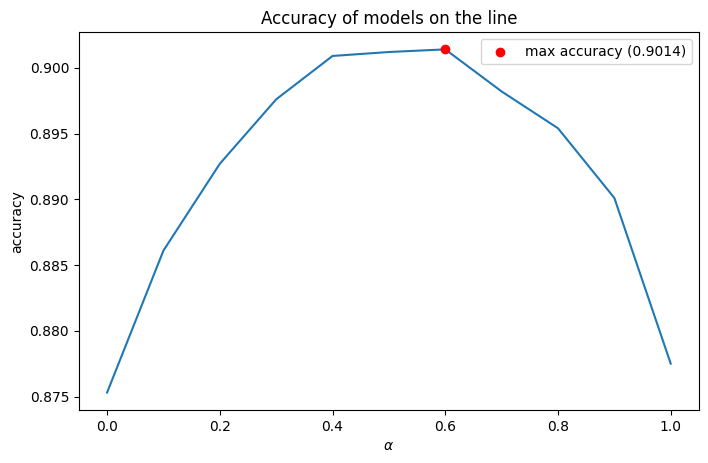

In [ ]:
plt.figure(figsize=(8, 5), dpi=100)
plt.plot(alphas, acc_results)
max_idx = np.argmax(acc_results)
plt.title('Accuracy of models on the line')
plt.xlabel(r'$\alpha$')
plt.ylabel('accuracy')
plt.scatter(alphas[max_idx], acc_results[max_idx],
            color='red', zorder=100, label=f'max accuracy ({acc_results[max_idx]})')
plt.legend()
plt.show()

In [ ]:
clear_gpu(trainer.model)

In [ ]:
device = 'cuda:0'
model1 = WideResNet(28, 10, 0.3, 10, LinesConv, LinesBN).to(device)
model2 = WideResNet(28, 10, 0.3, 10, LinesConv, LinesBN).to(device)
ensemble = Ensemble(model1, model2, f'{save_root_path}/line_conv_69.pt', device)
trainer = get_trainer_for_val(ensemble, 'basetrainer',
                              f'{save_root_path}/line_conv_69.pt',
                              2, nn.CrossEntropyLoss(), load=False)
train_loader, val_loader = get_data(42)

Wide-Resnet 28x10
Wide-Resnet 28x10
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
alphas = np.linspace(0, 1, num=11)
loss_results, acc_results = validate_ensemble(alphas, trainer, train_loader, val_loader)

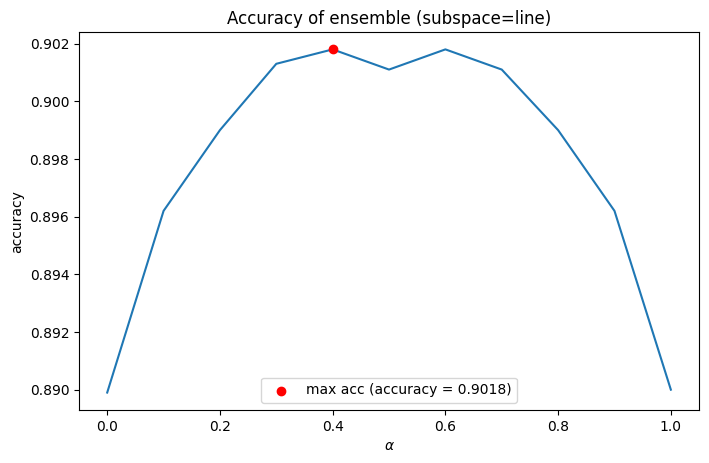

In [ ]:
plt.figure(figsize=(8, 5), dpi=100)
plt.plot(alphas, acc_results)
max_idx = np.argmax(acc_results)
plt.title('Accuracy of ensemble (subspace=line)')
plt.xlabel(r'$\alpha$')
plt.ylabel('accuracy')
plt.scatter(alphas[max_idx], acc_results[max_idx],
            color='red', zorder=100, label=f'max acc (accuracy = {acc_results[max_idx]})')
plt.legend()
plt.show()

In [13]:
device = 'cuda:0'
model = WideResNet(28, 10, 0.3, 10, SimplexConv3, SimplexBN3, last_conv=True).to(device)
trainer = get_trainer_for_val(model, 'trainer', f'{save_root_path}/simplex_59.pt', 3, nn.CrossEntropyLoss())
trainer.sample_from_simplex()
train_loader, val_loader = get_data(42)

Wide-Resnet 28x10


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [14]:
simplex_loss, simplex_acc = trainer.validate(val_loader, train_loader, update_bn=True)

Updating batchnorm statistics:   0%|          | 0/391 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

In [15]:
print(f'Simplex accuracy: {simplex_acc}')

Simplex accuracy: 0.8788
